# Clonal competition model

In [1]:
import evolutionary_functions as ev

import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.integrate as it
from scipy.stats import kde
import pandas as pd
from scipy.special import gamma
from IPython.display import clear_output
import scipy.optimize as opt
import os
import datetime

# plotting defaults
import matplotlib
matplotlib.rc_file_defaults()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Lato'


### Import data

In [2]:
# number of quantiles for plotting: choose 3 or 4
# must be 3 if using pre-calculated values for density
number_of_quantiles = 3

# import age distribution and quantile labels
biobank_bins_quantiles = pd.read_csv('inputs_participants/biobank_bins_quantiles.tsv', sep='\t').rename(
    columns={f'quantile_labels_{number_of_quantiles}': 'quantile_labels'})[
    ['Age.when.attended.assessment.centre_v0', 'age_count', 'quantile_labels']]
number_of_individuals = biobank_bins_quantiles.age_count.sum()

In [3]:
trimming_thresholds = {'DNMT3A R882H':0.03603267304887714,
                       'DNMT3A R882C':0.03641125564466615,
                       'DNMT3A Y735C': 0.02, #0.031021452650779963,
                       'DNMT3A P904L': 0.03050625833173621,
                       'DNMT3A R736H': 0.03875482257879603,
                       'DNMT3A R771*': 0.03427038103403027,
                       'DNMT3A R736C': 0.02691079729604606,
                       'DNMT3A R326C': 0.028204184173756756,
                       'DNMT3A R598*': 0.03076131339432306,
                       'DNMT3A R729W': 0.03783540677226178,
                       'GNB1 K57E': 0.14153654536164767,
                       'DNMT3A R320*': 0.028631527128345668,
                       'SRSF2 P95H': 0.04347979091423723,
                       'JAK2 V617F': 0.13520099097390018,
                       'SF3B1 K700E': 0.04598031864820239,
                       'SRSF2 P95R': 0.02953317476037705,
                       'SRSF2 P95L': 0.043065694094422076,
                       'DNMT3A R882S': 0.03679934975977073,
                       'IDH2 R140Q': 0.06330736020657143,
                       'SF3B1 K666N': 0.06919892423070759}

In [4]:
ukb_variants = pd.read_csv('inputs_variants/ukb_variants_trimmed_WIP.tsv', sep='\t')

# attach age quantile data
ukb_variants_quantiles = pd.merge(ukb_variants, biobank_bins_quantiles[['Age.when.attended.assessment.centre_v0', f'quantile_labels']], on='Age.when.attended.assessment.centre_v0', how='left')

# create useful dictionary of variant dataframes
ukb_variants_dict = {}
for varid in ukb_variants_quantiles.varID.unique():
    ukb_variants_dict[varid] = ukb_variants_quantiles[ukb_variants_quantiles['varID'] == varid].reset_index(drop=True)

### Supplementary Figure 19

Clonal competition at hotspots

In [10]:
df_rows = []
for varid in ukb_variants_dict.keys():
    res = pd.read_csv(f'../results_recall/clonal_comp_optimiser/mac_mini_all_hotspots/{"_".join(varid.split(" "))}-only-recursive.tsv', sep='\t')
    final_row = res.iloc[-1]
    df_rows.append({'gene':varid, 'mu1':final_row['mu1'], 'mu2':final_row['mu2'], 's1':final_row['s1'], 's2':final_row['s2']})

clonal_competition_hotspots = pd.DataFrame(df_rows)
clonal_competition_hotspots['n_variants'] = clonal_competition_hotspots['gene'].map({varid:len(ukb_variants_dict[varid]) for varid in ukb_variants_dict.keys()})
clonal_competition_hotspots = clonal_competition_hotspots.sort_values('n_variants', ascending=False)


In [19]:
clonal_competition_hotspots= pd.read_csv('results_files/competition_hotspots.tsv', sep='\t')

In [20]:
hotspots_to_plot = ['DNMT3A R882H', 'DNMT3A R882C', 'DNMT3A P904L', 'DNMT3A R736C', 'DNMT3A R771*', 'DNMT3A R326C', 'DNMT3A R736H', 'DNMT3A R598*', 'DNMT3A R320*']

In [59]:
# pre-calculated variant density. Full calculation takes several hours
overall_density_dict = np.load('results_files/pre_calculated_density/hotspot_overall_density_2025.npy', allow_pickle=True).item()
quantile_density_dict = np.load('results_files/pre_calculated_density/hotspot_4quantile_density_2025.npy', allow_pickle=True).item()

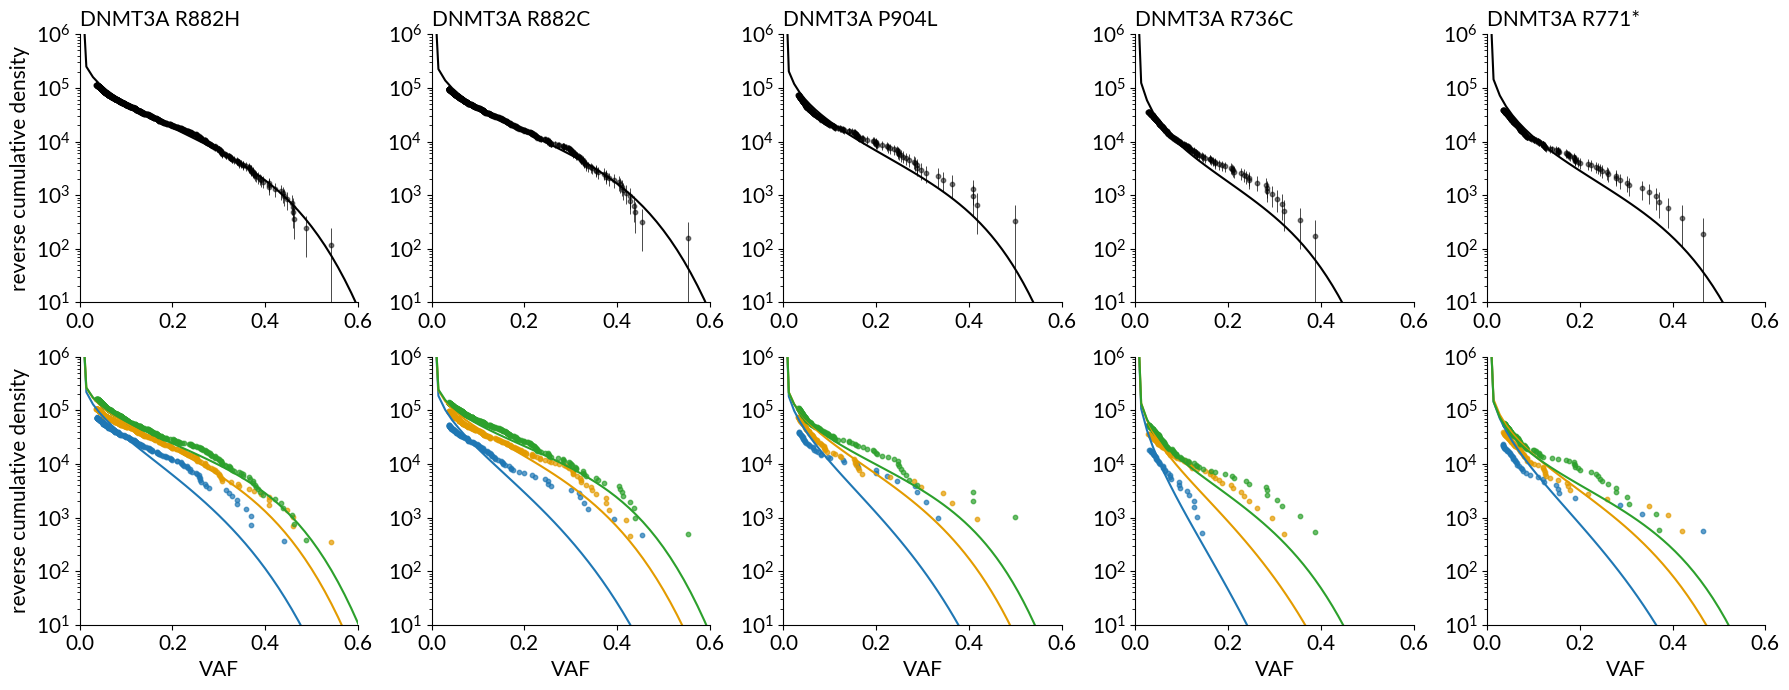

In [22]:
# plot results
fig, ax = plt.subplots(2, 5, figsize=[18, 7])
col = 0
quantile_colour_list = ['tab:blue', '#e39b00', 'tab:green', 'C3']
index_range = np.arange(0, 5)
bins_age = np.arange(40, 70, 3)

for i, varid in enumerate(hotspots_to_plot):
    if i not in index_range:
        continue

    variant_quantiles = ukb_variants_dict[varid]
    opt_row = clonal_competition_hotspots[clonal_competition_hotspots.gene == varid]
    mu1, s1, mu2, s2= opt_row[['mu1', 's1', 'mu2', 's2']].squeeze()
    #if sigma < 0: sigma = -sigma
    ev.overall_density_plot(ax[0, col], variant_quantiles, mu1, overall_density_dict[varid], number_of_individuals, colour='k')
    ev.quantile_density_plot(ax[1, col], variant_quantiles, mu1, quantile_density_dict[varid], number_of_quantiles, quantile_colour_list, biobank_bins_quantiles)
    #ax[0, col].set_title(varid+'\n'+f'n = {len(variant_quantiles)}, D = {int(variant_quantiles.depth.mean())}', fontsize=15)
    ax[0, col].set_title(varid, fontsize=15, loc='left')
    ax[1, col].set_xlabel('VAF')
    #ax[0, col].text(0.4, 1e5, fr'$\mu = {mu:.2g}$'+'\n' + r'$\bar{s}$ = '+ f'{np.round(sbar*100, 1)}%'+'\n'+fr'$\sigma = {sigma:.2g}$')

    for row in range(2):
        ax[row, col].set_yscale('log')
        ax[row, col].set_ylim(1e1, 1e6)
        ax[row, col].set_xlim(0, 0.6)
        ax[row, 0].set_ylabel('reverse cumulative density')
        ax[row, col].grid(False)
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)

    #plot_prevalence(ax[2, col], variant_quantiles, biobank_healthy_pheno, bins_age, prevalences[varid], colour='k', logscale=False)

    col += 1
plt.tight_layout()
plt.show()

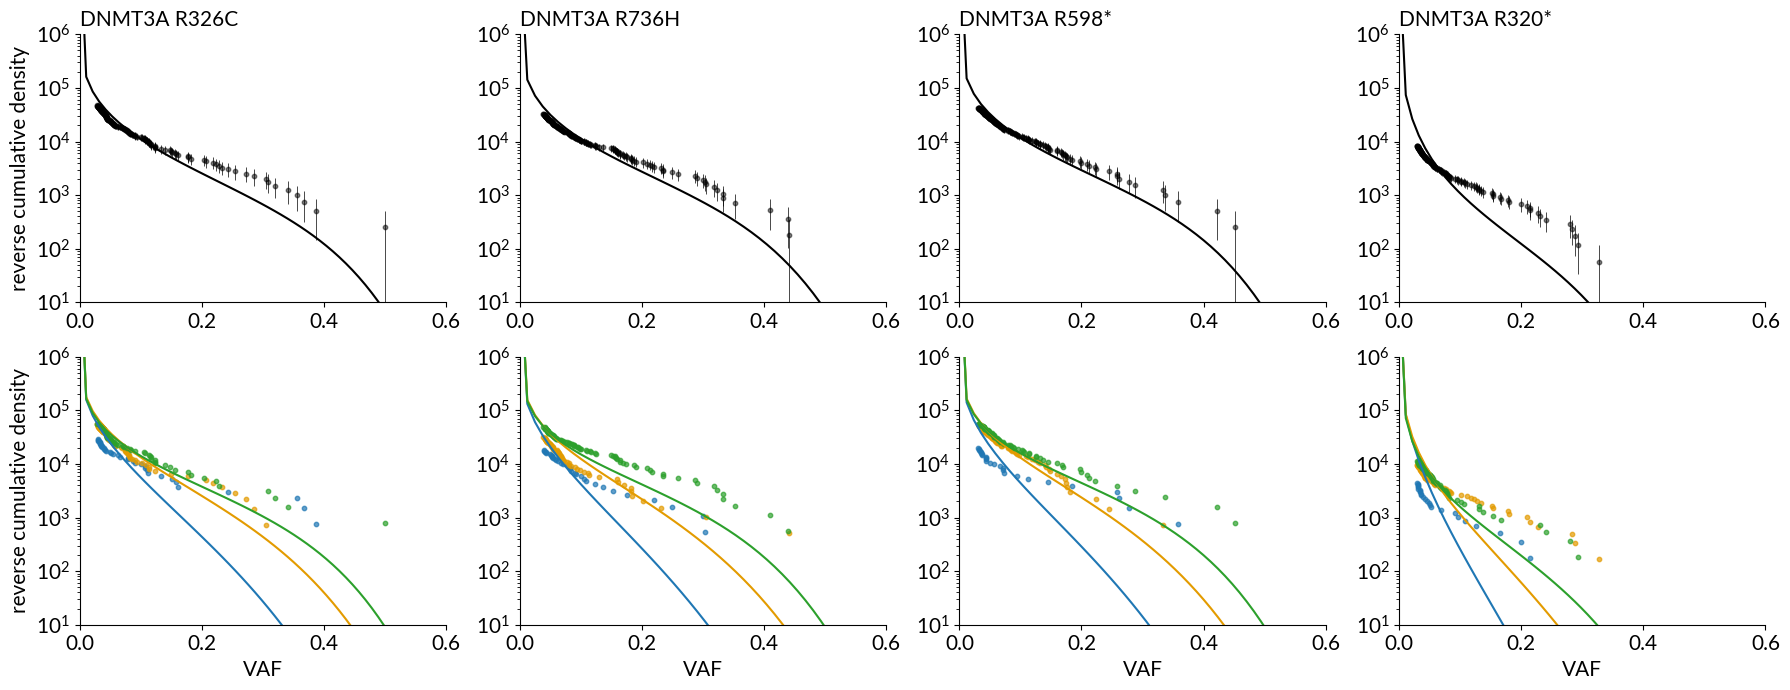

In [16]:
# plot results
fig, ax = plt.subplots(2, 4, figsize=[18, 7])
col = 0
quantile_colour_list = ['tab:blue', '#e39b00', 'tab:green', 'C3']
index_range = np.arange(5, 10)
bins_age = np.arange(40, 70, 3)

for i, varid in enumerate(hotspots_to_plot):
    if i not in index_range:
        continue

    variant_quantiles = ukb_variants_dict[varid]
    opt_row = clonal_competition_hotspots[clonal_competition_hotspots.gene == varid]
    mu1, s1, mu2, s2= opt_row[['mu1', 's1', 'mu2', 's2']].squeeze()
    #if sigma < 0: sigma = -sigma
    ev.overall_density_plot(ax[0, col], variant_quantiles, mu1, overall_density_dict[varid], number_of_individuals, colour='k')
    ev.quantile_density_plot(ax[1, col], variant_quantiles, mu1, quantile_density_dict[varid], number_of_quantiles, quantile_colour_list, biobank_bins_quantiles)
    #ax[0, col].set_title(varid+'\n'+f'n = {len(variant_quantiles)}, D = {int(variant_quantiles.depth.mean())}', fontsize=15)
    ax[0, col].set_title(varid, fontsize=15, loc='left')
    ax[1, col].set_xlabel('VAF')
    #ax[0, col].text(0.4, 1e5, fr'$\mu = {mu:.2g}$'+'\n' + r'$\bar{s}$ = '+ f'{np.round(sbar*100, 1)}%'+'\n'+fr'$\sigma = {sigma:.2g}$')

    for row in range(2):
        ax[row, col].set_yscale('log')
        ax[row, col].set_ylim(1e1, 1e6)
        ax[row, col].set_xlim(0, 0.6)
        ax[row, 0].set_ylabel('reverse cumulative density')
        ax[row, col].grid(False)
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)

    #plot_prevalence(ax[2, col], variant_quantiles, biobank_healthy_pheno, bins_age, prevalences[varid], colour='k', logscale=False)

    col += 1
plt.tight_layout()
plt.show()

### Supplementary Figure 20

Competition across whole genes

In [51]:
clonal_competition_genes = pd.read_csv('results_files/competition_genes.tsv', sep='\t')

In [52]:
genes_pass = genes_pass_competition = ['TET2', 'ASXL1', 'PPM1D', 'U2AF1', 'YLPM1', 'ZNF318', 'MYD88', 'GNAS']

In [53]:
# import variants
bolton_ch = pd.read_csv('inputs_variants/bolton_ch_healthy_curated.tsv', sep='\t')

# attach quantile labels
bolton_ch = pd.merge(bolton_ch, biobank_bins_quantiles[['Age.when.attended.assessment.centre_v0', 'quantile_labels']], on='Age.when.attended.assessment.centre_v0', how='left')
bolton_ch = bolton_ch.rename(columns={'sample_ID':'ID_v0'})

# organise into a dict gene-by-gene
bolton_ch_dict = {}
for gene in bolton_ch.gene.value_counts().index: # so that the dict keys come out in prevalence order
    if (gene in genes_pass) & (gene != 'IDH2'):
        bolton_ch_dict[gene] = bolton_ch[bolton_ch.gene == gene].reset_index(drop=True)

In [54]:
# trimming
bolton_trimming_thresholds = {'DNMT3A': 0.04,
                              'TET2':0.04, 
                              'ASXL1':0.03409090909090909,
                              'TP53':0.047619047619047616,
                              'PPM1D':0.03896103896103896,
                              'SF3B1':0.058823529411764705,
                              'U2AF1':0.034482758620689655,
                              'GNB1':0.10714285714285714,
                              'SRSF2':0.037037037037037035,
                              'CBL':0.06, 
                              'ATM':0.04,
                              'YLPM1':0.0410958904109589,
                              'ZBTB33':0.05,
                              'MYD88':0.041666666666666664,
                              'ZNF318': 0.04225352112676056,
                              'JAK2':0.1111111111111111,
                              'GNAS':0.07142857142857142}

In [55]:
# Introduce low VAF cutoff
bolton_ch_dict_trimmed = {}
for gene in bolton_ch_dict.keys():
    variants = bolton_ch_dict[gene]
    #D = int(variants.depth.mean())
    variants_trimmed = variants[variants.VAF >= bolton_trimming_thresholds[gene]].reset_index(drop=True)
    bolton_ch_dict_trimmed[gene] = variants_trimmed

In [56]:
# import pre-calculated density (full calculation takes several hours)
bolton_overall_density_dict = np.load('results_files/pre_calculated_density/bolton_overall_density_2025.npy', allow_pickle=True).item()
bolton_quantile_density_dict = np.load('results_files/pre_calculated_density/bolton_4quantile_density_2025.npy', allow_pickle=True).item()

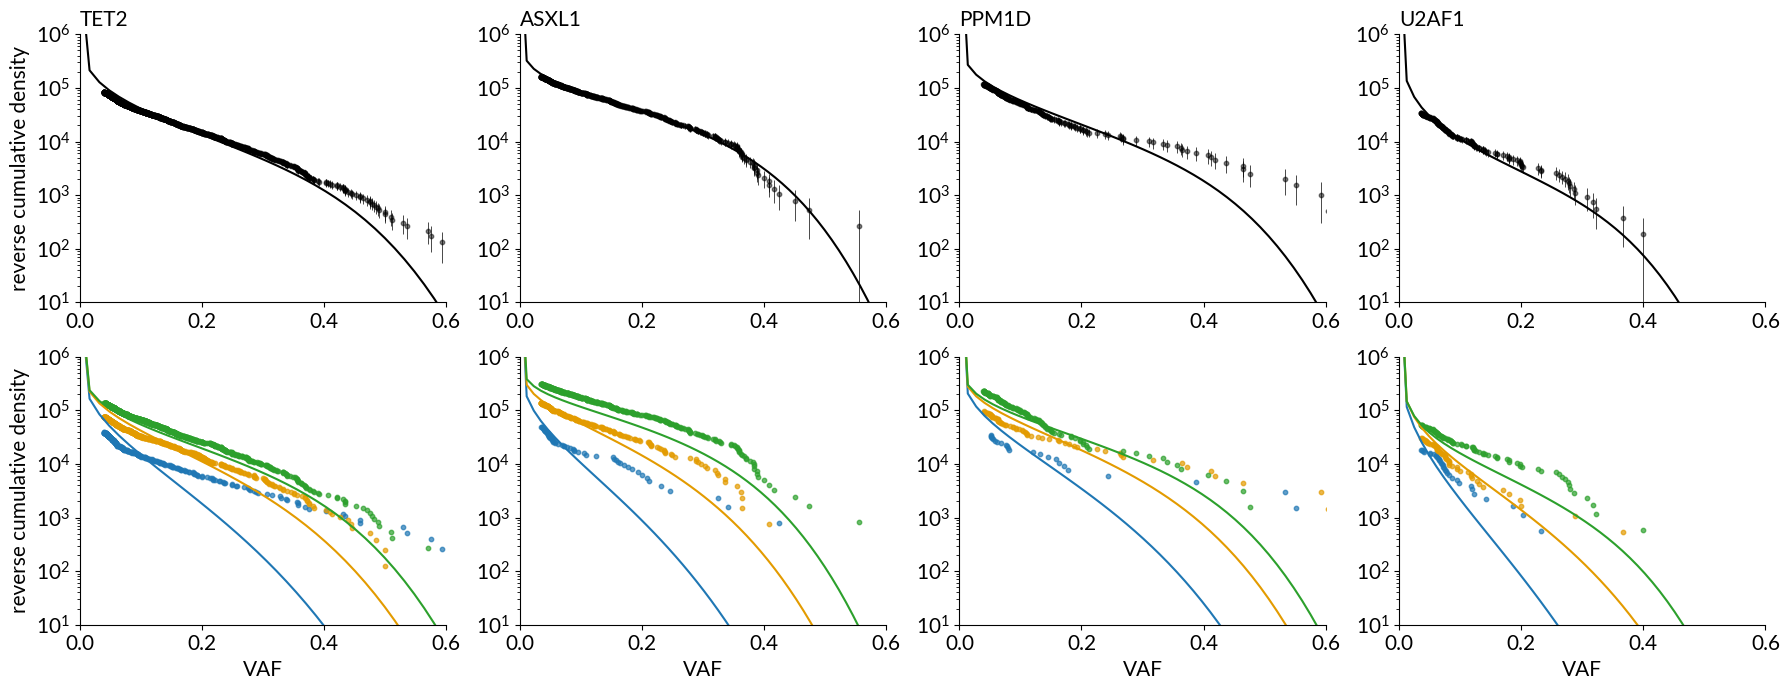

In [57]:
# plot results
fig, ax = plt.subplots(2, 4, figsize=[18, 7])
col = 0
quantile_colour_list = ['tab:blue', '#e39b00', 'tab:green', 'C3']
index_range = np.arange(0, 4)
#bins_age = np.arange(40, 70, 3)
i = 0
for gene in clonal_competition_genes.gene:
    if gene in ['DNMT3A', 'TP53', 'ZBTB33', 'ATM']: continue
    if i not in index_range:
        i += 1
        continue

    variant_quantiles = bolton_ch_dict_trimmed[gene]
    opt_row = clonal_competition_genes[clonal_competition_genes.gene == gene]
    mu1, s1, mu2, s2= opt_row[['mu1', 's1', 'mu2', 's2']].squeeze()
    #if sigma < 0: sigma = -sigma
    ev.overall_density_plot(ax[0, col], variant_quantiles, mu1, bolton_overall_density_dict[gene], number_of_individuals, colour='k')
    ev.quantile_density_plot(ax[1, col], variant_quantiles, mu1, bolton_quantile_density_dict[gene], number_of_quantiles, quantile_colour_list, biobank_bins_quantiles)
    #ax[0, col].set_title(gene+'\n'+f'n = {len(variant_quantiles)}, D = {int(variant_quantiles.depth.mean())}', fontsize=15)
    ax[0, col].set_title(gene, fontsize=15, loc='left')
    ax[1, col].set_xlabel('VAF')
    #ax[0, col].text(0.4, 1e5, fr'$\mu = {mu:.2g}$'+'\n' + r'$\bar{s}$ = '+ f'{np.round(sbar*100, 1)}%'+'\n'+fr'$\sigma = {sigma:.2g}$')

    for row in range(2):
        ax[row, col].set_yscale('log')
        ax[row, col].set_ylim(1e1, 1e6)
        ax[row, col].set_xlim(0, 0.6)
        ax[row, 0].set_ylabel('reverse cumulative density')
        ax[row, col].grid(False)
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)

    #plot_prevalence(ax[2, col], variant_quantiles, biobank_healthy_pheno, bins_age, prevalences_bolton[gene], colour='k', logscale=False)
    i += 1
    col += 1
plt.tight_layout()
plt.show()

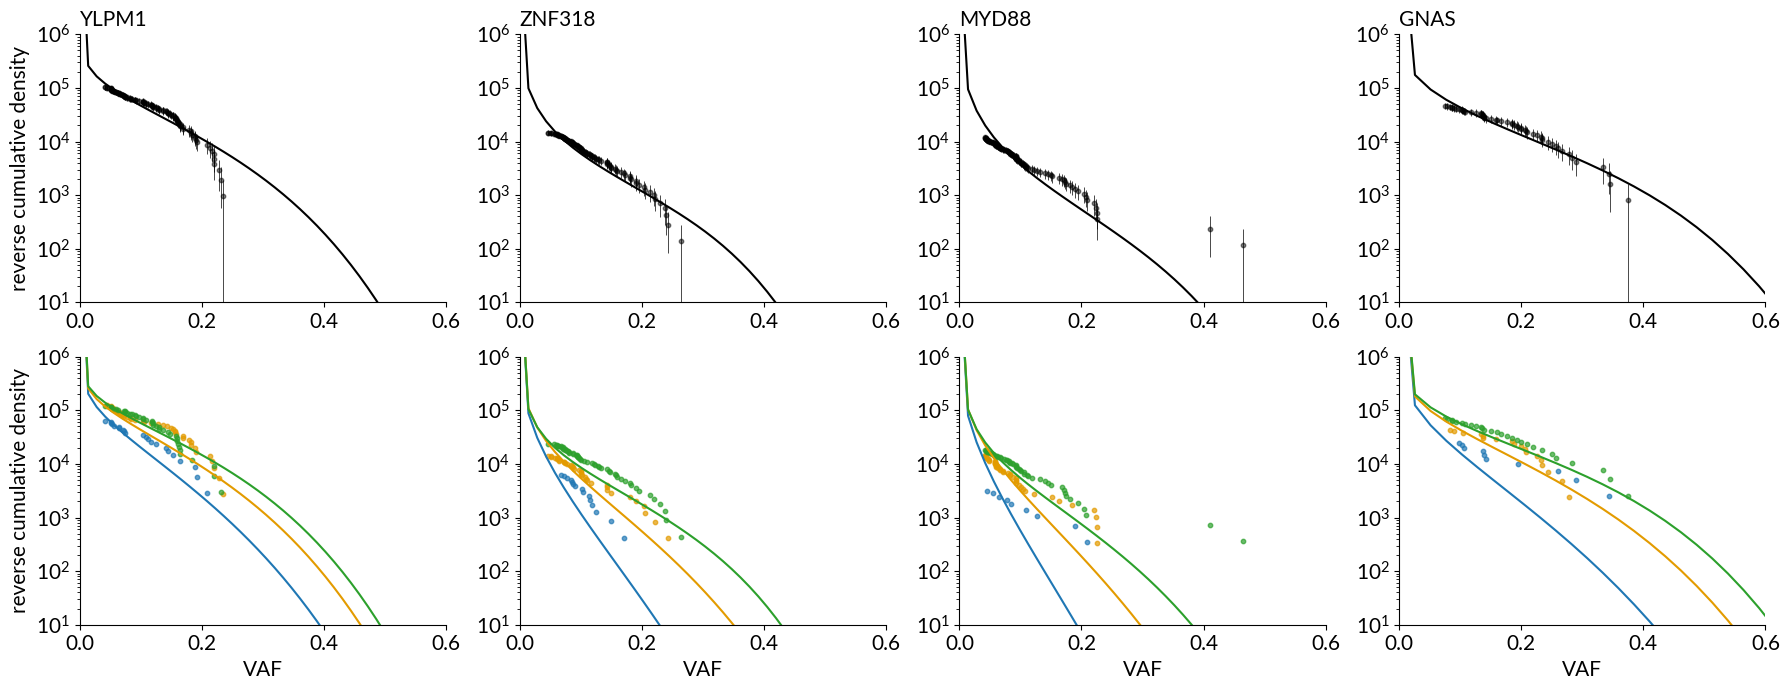

In [58]:
# plot results
fig, ax = plt.subplots(2, 4, figsize=[18, 7])
col = 0
quantile_colour_list = ['tab:blue', '#e39b00', 'tab:green', 'C3']
index_range = np.arange(4, 8)
#bins_age = np.arange(40, 70, 3)
i = 0
for gene in clonal_competition_genes.gene:
    if gene in ['DNMT3A', 'TP53', 'ZBTB33', 'ATM']: continue
    if i not in index_range:
        i += 1
        continue

    variant_quantiles = bolton_ch_dict_trimmed[gene]
    opt_row = clonal_competition_genes[clonal_competition_genes.gene == gene]
    mu1, s1, mu2, s2= opt_row[['mu1', 's1', 'mu2', 's2']].squeeze()
    #if sigma < 0: sigma = -sigma
    ev.overall_density_plot(ax[0, col], variant_quantiles, mu1, bolton_overall_density_dict[gene], number_of_individuals, colour='k')
    ev.quantile_density_plot(ax[1, col], variant_quantiles, mu1, bolton_quantile_density_dict[gene], number_of_quantiles, quantile_colour_list, biobank_bins_quantiles)
    #ax[0, col].set_title(gene+'\n'+f'n = {len(variant_quantiles)}, D = {int(variant_quantiles.depth.mean())}', fontsize=15)
    ax[0, col].set_title(gene, fontsize=15, loc='left')
    ax[1, col].set_xlabel('VAF')
    #ax[0, col].text(0.4, 1e5, fr'$\mu = {mu:.2g}$'+'\n' + r'$\bar{s}$ = '+ f'{np.round(sbar*100, 1)}%'+'\n'+fr'$\sigma = {sigma:.2g}$')

    for row in range(2):
        ax[row, col].set_yscale('log')
        ax[row, col].set_ylim(1e1, 1e6)
        ax[row, col].set_xlim(0, 0.6)
        ax[row, 0].set_ylabel('reverse cumulative density')
        ax[row, col].grid(False)
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)

    #plot_prevalence(ax[2, col], variant_quantiles, biobank_healthy_pheno, bins_age, prevalences_bolton[gene], colour='k', logscale=False)
    i += 1
    col += 1
plt.tight_layout()
plt.show()

### Supplementary Fig. 13



In [ ]:
filename_list = ['../results_recall/sim_experiments/competition/competition_longitudinal_1e-7_0.20_1e-5_0.23/clone_histories.npy',
                 '../results_recall/sim_experiments/competition/competition_longitudinal_1e-7_0.20_0.6e-5_0.23/clone_histories.npy',
                 '../results_recall/sim_experiments/competition/competition_longitudinal_1e-7_0.20_0.2e-5_0.23/clone_histories.npy',
                 '../results_recall/sim_experiments/competition/competition_longitudinal_1e-7_0.20_gladys_background_to_0.105/clone_histories.npy',
                 '../results_recall/sim_experiments/competition/competition_longitudinal_1e-7_0.20_gladys_background_to_0.035/clone_histories.npy']

fig, ax = plt.subplots(len(filename_list), 6, figsize=[20, 15])

for row in range(len(filename_list)):
    clone_histories = np.load(filename_list[row], allow_pickle=True).item()
    s_r882 = 0.20
    interesting_clones = []
    for clone_ID in list(clone_histories.keys())[1:]:
        if clone_ID[1][1] == s_r882:
            if (len(clone_histories[clone_ID]['times']) > 100) & (min(clone_histories[clone_ID]['times']) < 100):
                #print(clone_ID, clone_histories[clone_ID]['person_ID'])
                interesting_clones.append(clone_histories[clone_ID]['person_ID'])

    col = 0
    for col, person_ID in enumerate(interesting_clones[:5]):

        clones = {}
        for clone_ID in clone_histories.keys():
            if clone_histories[clone_ID]['person_ID'] == person_ID:
                if clone_ID != ((0, 0.0),):
                    clones[clone_ID] = clone_histories[clone_ID]

        ev.plot_clone_expansion_with_no_negative_bound(ax[row, col], clones, marker_style='x', marker_color='k', y_range=(0, 0.5))
        ax[row, col].set_xticks([0, 20, 40, 60])
    #ax[i].set_title(person_ID)

    # clone proportion plot (final column)
    col = 5
    all_people = []
    for clone_ID in clone_histories.keys():
        if clone_ID == ((0, 0.0),): continue
        person_ID = clone_histories[clone_ID]['person_ID']
        if person_ID not in all_people:
            all_people.append(person_ID)

    proportions = {}
    for person_ID in all_people:
        clones = {}
        for clone_ID in clone_histories.keys():
            if clone_ID == ((0, 0.0),): continue
            if clone_histories[clone_ID]['person_ID'] == person_ID:
                clones[clone_ID] = clone_histories[clone_ID]

        proportions[person_ID] = ev.calculate_clone_proportions(clones)
    mean_proportions = ev.calculate_mean_proportions(proportions)

    for person_ID in all_people[1:1000]:
        ax[row, col].plot(proportions[person_ID].keys(), proportions[person_ID].values(), lw=0.5, alpha=0.05, color='k')
    ax[row, col].plot(mean_proportions.keys(), mean_proportions.values(), lw=2, color='red')
    age_ticks = np.arange(0, 80, 10)
    ax[row, col].set_xticks(age_ticks*5, age_ticks)
    ax[row, col].set_ylim(0, 1)
    ax[row, col].set_ylabel('cell fraction')
    ax[row, col].set_xlabel('age')
    ax[row, col].set_xticks(np.array([0, 20, 40, 60])*5)
    ax[row, col].set_xticklabels([0, 20, 40, 60])
    #ax[i].set_title('Background rate: '+u_background)

    # legend
    if row == 0:
        from matplotlib.lines import Line2D

        legend_elements = [Line2D([0], [0], lw=2, color='red', label='simulation average')]
        ax[row, col].legend(handles=legend_elements, loc='upper left', fontsize=8)


#plt.tight_layout()
#plt.savefig('results_recall/recall_publication_plots/competition_proportion_sims.pdf')
#plt.show()


plt.tight_layout()
#plt.savefig('results_recall/recall_publication_plots_supplementary/competition_sims_combined.pdf')

plt.show()